In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import torch
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from transformers import BertForSequenceClassification
from bertviz import head_view, model_view

from utils.data_preparation import get_emotion_dataset, naive_bayes_preprocessing, bert_preprocessing
from models.naive_bayes import NaiveBayes


/Users/jantiegges/.pyenv/versions/3.11.5/envs/a3-comp551/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Naive Bayes

In [2]:
processed_data, _ = naive_bayes_preprocessing(
    remove_stopwords=True, 
    use_bigrams=False
)
X_train, y_train = processed_data['train']
X_val, y_val = processed_data['validation']
X_test, y_test = processed_data['test']

In [3]:
nb = NaiveBayes(
    alpha_prior=0,
    alpha_likelihood=1.0,
)
nb.fit(X_train, y_train)
predictions = nb.predict(X_test)
acc = nb.evaluate_acc(y_test, predictions)

In [4]:
print(f"Accuracy of Naive Bayes model: {acc:.4f}")

Accuracy of Naive Bayes model: 0.7945


## Grid Search

In [5]:
with open('out/nb_grid_search_results.pkl', 'rb') as handle:
    grid_search_results = pickle.load(handle)
print(grid_search_results.head())

   alpha_prior  alpha_likelihood  use_bigrams  remove_stopwords  val_accuracy
0       100000               0.2         True              True        0.8350
1        10000               0.2         True              True        0.8320
2         1000               0.2         True              True        0.8285
3        10000               0.5        False              True        0.8280
4       100000               1.0        False              True        0.8270


## Results

Best params:
alpha_prior         100000
alpha_likelihood       0.2
use_bigrams           True
remove_stopwords      True
val_accuracy         0.835
Name: 0, dtype: object
              precision    recall  f1-score   support

           0     0.8367    0.9174    0.8752       581
           1     0.8560    0.8978    0.8764       695
           2     0.7338    0.6415    0.6846       159
           3     0.8683    0.7673    0.8147       275
           4     0.8257    0.8036    0.8145       224
           5     0.7941    0.4091    0.5400        66

    accuracy                         0.8385      2000
   macro avg     0.8191    0.7394    0.7676      2000
weighted avg     0.8369    0.8385    0.8343      2000



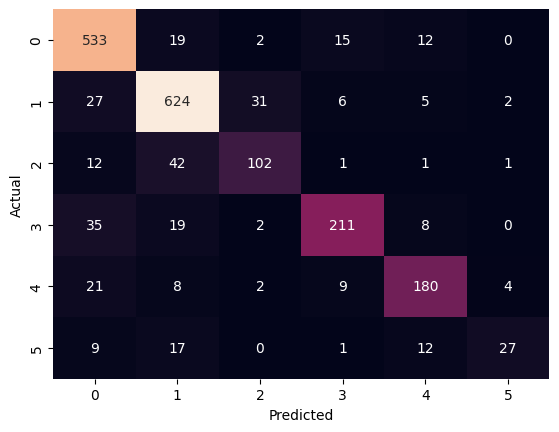

In [6]:
# take params from best model
best_params = grid_search_results.iloc[0]
print(f"Best params:\n{best_params}")

processed_data, vectorizer = naive_bayes_preprocessing(
    remove_stopwords=best_params['remove_stopwords'], 
    use_bigrams=best_params['use_bigrams']
)
X_train, y_train = processed_data['train']
X_test, y_test = processed_data['test']

nb = NaiveBayes(
    alpha_prior=best_params['alpha_prior'],
    alpha_likelihood=best_params['alpha_likelihood'],
)
nb.fit(X_train, y_train)
predictions = nb.predict(X_test)

print(classification_report(y_test, predictions, digits=4))
cm = confusion_matrix(y_test, predictions)
sns.heatmap(cm, annot=True, fmt='d', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [7]:
feature_names = vectorizer.get_feature_names_out()
class_log_probabilities = nb.feature_log_prob_
class_names = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

for i, class_probabilities in enumerate(class_log_probabilities):
    # sort features by their log prob
    sorted_features = np.argsort(class_probabilities)
    
    # get the top n feature
    top_features = sorted_features[-5:][::-1]
    top_scores = class_probabilities[top_features]
    top_scores = np.exp(top_scores)
    top_feature_names = feature_names[top_features]
    
    print(f"Class {i} ({class_names[i]}):", end=' ')
    for feature_name, score in zip(top_feature_names, top_scores):
        print(f"'{feature_name}' ({score:.4f})", end=' ')
    print()


Class 0 (sadness): 'feel' (0.0362) 'feeling' (0.0167) 'like' (0.0095) 'im' (0.0075) 'feel like' (0.0057) 
Class 1 (joy): 'feel' (0.0368) 'feeling' (0.0144) 'like' (0.0094) 'im' (0.0075) 'feel like' (0.0058) 
Class 2 (love): 'feel' (0.0221) 'feeling' (0.0090) 'like' (0.0073) 'im' (0.0046) 'feel like' (0.0044) 
Class 3 (anger): 'feel' (0.0270) 'feeling' (0.0134) 'like' (0.0071) 'im' (0.0063) 'feel like' (0.0047) 
Class 4 (fear): 'feel' (0.0241) 'feeling' (0.0148) 'im' (0.0064) 'like' (0.0051) 'just' (0.0034) 
Class 5 (surprise): 'feel' (0.0121) 'feeling' (0.0071) 'im' (0.0031) 'like' (0.0031) 'amazed' (0.0023) 


- the relatively small differences in probabilities between the same words across classes suggest that there is a significant overlap in how these words are used to express different emotions
- the presence of certain words with unique associations to an emotion (like 'amazed' for surprise) could be more discriminative and valuable for the classification task

# BERT

In [8]:
bert_processed_data, tokenizer = bert_preprocessing()
input_ids_train, attention_mask_train, y_train = bert_processed_data['train']
input_ids_val, attention_mask_val, y_val = bert_processed_data['validation']
input_ids_test, attention_mask_test, y_test = bert_processed_data['test']

## Out of the Box

              precision    recall  f1-score   support

           0     0.9689    0.9639    0.9664       581
           1     0.9415    0.9496    0.9456       695
           2     0.8400    0.7925    0.8155       159
           3     0.9398    0.9091    0.9242       275
           4     0.8636    0.9330    0.8970       224
           5     0.7619    0.7273    0.7442        66

    accuracy                         0.9265      2000
   macro avg     0.8860    0.8792    0.8821      2000
weighted avg     0.9265    0.9265    0.9262      2000



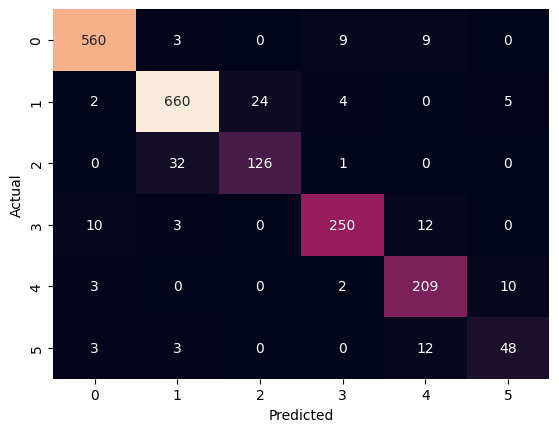

In [9]:
# load model
model_version = 'bhadresh-savani/bert-base-uncased-emotion'
bert_oob = BertForSequenceClassification.from_pretrained(model_version, output_attentions=True)
bert_oob.load_state_dict(torch.load("out/bert_oob.bin"))

with open('out/bert_oob_predictions.pkl', 'rb') as handle:
    predictions = pickle.load(handle)
with open('out/bert_oob_attentions.pkl', 'rb') as handle:
    attentions = pickle.load(handle)

print(classification_report(y_test, predictions, digits=4))
cm = confusion_matrix(y_test, predictions)
sns.heatmap(cm, annot=True, fmt='d', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [10]:
# find samples of class X that were correctly classified and misclassified
class_idx = 5 

correctly_classified_index = None
misclassified_index = None

for i, (pred, actual) in enumerate(zip(predictions, y_test)):
    if pred == actual == class_idx:
        correctly_classified_index = i
        if misclassified_index is not None:
            break
    elif pred != actual and actual == class_idx:
        misclassified_index = i
        if correctly_classified_index is not None:
            break

print("Correctly Classified Example Index:", correctly_classified_index)
print("Misclassified Example Index:", misclassified_index)


Correctly Classified Example Index: 69
Misclassified Example Index: 72


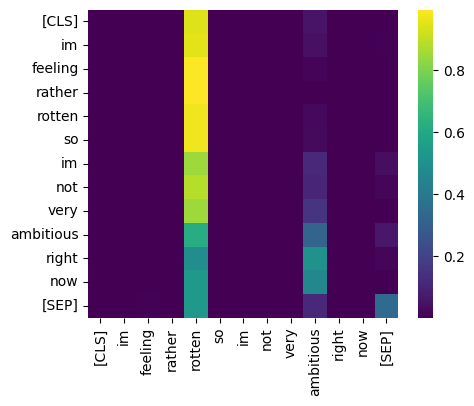

In [11]:
layer = 9 
head = 7  
sample_index = 0  # Index of the sample to analyze

selected_attention = attentions[layer][:, head, :, :]
non_padding_mask = input_ids_test[sample_index] != 0 # filter out padding tokens

# Apply mask to tokens and attention
tokens = np.array(tokenizer.convert_ids_to_tokens(input_ids_test[sample_index]))[non_padding_mask]
filtered_attention = selected_attention[sample_index][non_padding_mask][:, non_padding_mask]

plt.figure(figsize=(5, 4))
sns.heatmap(filtered_attention, xticklabels=tokens, yticklabels=tokens, cmap='viridis')
plt.show()


In [12]:
sample_index = 69  # idx of the sample to analyze

# select a sentence for analysis
dataset = get_emotion_dataset()['test']
sentence = dataset[sample_index]["text"]

# tokenize the sentence
inputs = tokenizer.encode_plus(sentence, return_tensors='pt', add_special_tokens=True)
input_ids = inputs['input_ids']

# get attentions
outputs = bert_oob(input_ids)
attention = outputs[-1]

# convert input_ids to tokens for visualization
input_id_list = input_ids[0].tolist() # Batch index 0
tokens = tokenizer.convert_ids_to_tokens(input_id_list)

head_view(attention, tokens)

<IPython.core.display.Javascript object>

In [13]:
model_view(attention, tokens)

<IPython.core.display.Javascript object>

## Fine Tuning (entire model)

In [14]:
# TODO

## Fine Tuning (only classifier)

In [15]:
# TODO